In [1]:
import cv2
import glob
import tensorflow as tf
import numpy as np
import pickle
import os
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls
%cd drive/My Drive/ImCap
! git clone https://github.com/deeplearningunb/ImageCaptioning.git

[Errno 2] No such file or directory: 'drive/My Drive/ImCap'
/content/drive/My Drive/ImCap
Cloning into 'ImageCaptioning'...
remote: Enumerating objects: 8138, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 8138 (delta 13), reused 31 (delta 11), pack-reused 8105
Receiving objects: 100% (8138/8138), 1.09 GiB | 23.45 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Checking out files: 100% (8098/8098), done.


In [ ]:
# image related data
images_name = []
images_list = []
images_features = {}
img_features_path = os.path.join('/content/drive/MyDrive/ImCap/ImageCaptioning/dataset/pkl/train2048.pkl')

# caption related data
captions_list = []
captions_mapped = {}
vocab = {}

# encode model for preprocessing
encode_model = None

In [ ]:
path = '/content/drive/MyDrive/ImCap/ImageCaptioning/dataset/images/Flicker8k_Dataset/*.jpg'
for img in glob.glob(path):
    if not os.path.exists(img_features_path):
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (299,299))
        images_list.append(image)
    img = img.split('/')[-1]
    images_name.append(img)

In [ ]:
x = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')
encode_model = tf.keras.models.Model(x.input, x.layers[-2].output)

In [ ]:
if not os.path.exists(img_features_path):
    for j in range(0,len(images_list)):
        i = images_list[j].reshape(1,299,299,3)
        i = encode_model.predict(i).reshape(2048,)
        images_features[images_name[j]] = i

    with open(img_features_path, 'wb') as f:
        pickle.dump(images_features, f)
else:
    print('File already exist, opening...')
    with open(img_features_path, 'rb') as f:
        images_features = pickle.load(f)

File already exist, opening...


In [ ]:
f = open('/content/drive/MyDrive/ImCap/ImageCaptioning/dataset/text/Flickr8k.token.txt', 'rb')
captions_list = f.read().decode('utf-8').split('\n')

for i in captions_list:
    name = i.split('\t')[0][:-2]
    caption = i.split('\t')[1]
    caption = caption.lower()
    caption = 'sequencestart ' + caption + ' sequenceend'

    if name in images_name:
        if name not in captions_mapped:
            captions_mapped[name] = [caption]
        else:
            captions_mapped[name].append(caption)

In [ ]:
mapped_number = 1
for w in captions_mapped.values():
    for words in w:
        for word in words.split():
            if word not in vocab:
                vocab[word] = mapped_number
                mapped_number += 1

for i, w in captions_mapped.items():
    for words in w:
        mapped = []
        for word in words.split():
            mapped.append(vocab[word])

        captions_mapped[i][w.index(words)] = mapped

if not os.path.exists(vocab_path):
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)

In [ ]:
len(captions_mapped)

8091

In [ ]:
captions_mapped['1000268201_693b08cb0e.jpg']

[[1, 2, 3, 4, 2, 5, 6, 7, 8, 9, 2, 10, 11, 12, 4, 13, 14, 15, 16, 17],
 [1, 2, 18, 19, 20, 2, 21, 22, 16, 17],
 [1, 2, 23, 18, 8, 20, 2, 21, 24, 16, 17],
 [1, 2, 23, 18, 8, 25, 12, 26, 27, 24, 16, 17],
 [1, 2, 23, 18, 4, 2, 5, 6, 19, 20, 2, 21, 28, 16, 17]]

In [ ]:
MAX_LEN = 0
for img_name, captions in captions_mapped.items():
    for caption in captions:
        if len(caption) > MAX_LEN:
            MAX_LEN = len(caption)

In [ ]:
def create_seq(captions, photo):
    X1, X2, y = [], [], []
    for caption in captions:
        for i in range(1, len(caption)):
            in_seq, out_seq = caption[:i], caption[i]

            in_seq = tf.keras.preprocessing.sequence.pad_sequences(
                [in_seq], 
                maxlen=MAX_LEN)[0]

            out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=len(vocab) + 1)[0]
            
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
def generator():
    while True:
        for img_name, caption in captions_mapped.items():
            img = images_features[img_name]
            x1, x2, y = create_seq(caption, img)
            yield [x1, x2], y

In [ ]:
def architecture():
    # creating feature extractor model
    feature_model_input =  tf.keras.layers.Input(shape=(2048,))
    feature_model_dropout = tf.keras.layers.Dropout(0.5)(feature_model_input)
    feature_model_dense = tf.keras.layers.Dense(256, activation='relu')(feature_model_dropout)

    # creating recurrent model
    recurrent_model_input = tf.keras.layers.Input(shape=(MAX_LEN,))
    recurrent_model_embedding = tf.keras.layers.Embedding(len(vocab)+1, 256, mask_zero=True)(recurrent_model_input)
    recurrent_model_dropout = tf.keras.layers.Dropout(0.5)(recurrent_model_embedding)
    recurrent_model_lstm = tf.keras.layers.LSTM(256)(recurrent_model_dropout)

    # adding models 
    added_model = tf.keras.layers.Add()([feature_model_dense, recurrent_model_lstm])
    added_model_dense = tf.keras.layers.Dense(256, activation='relu')(added_model)
    output = tf.keras.layers.Dense(len(vocab)+1, activation='softmax')(added_model_dense)

    # creating keras model object
    model = tf.keras.models.Model(inputs=[feature_model_input, recurrent_model_input], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
# train the model, run epochs manually and save after each epoch
model = architecture()
epochs = 20
steps = len(captions_mapped)
for i in range(epochs):
	# create the data generator
	gen = generator()
	# fit for one epoch
	model.fit_generator(gen, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model.save('model_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


7084/8091 [=========================>....] - ETA: 1:59 - loss: 4.6185

KeyboardInterrupt: ignored

In [ ]:
# generate caption
def exctract_img_features(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (299,299))
    image = np.reshape(image, (1,299,299,3))
    features = encode_model.predict(image)
    return features

def word_by_token(value):
    for word, index in vocab.items():
        if index == value:
            return word
    return None

def generate_caption(model, img):
    text = ['sequencestart']
    caption = ' '

    for i in range(MAX_LEN):
        encoded = []
        for t in text:
            encoded.append(vocab[t])

        encoded = tf.keras.preprocessing.sequence.pad_sequences([encoded], maxlen=MAX_LEN)
        pred = model.predict([img, encoded], verbose=0)
        pred = np.argmax(pred)

        word = word_by_token(pred)

        if word  == 'sequenceend':
            break
        
        caption += ' ' + word
        text.append(word)

    return caption

model = tf.keras.models.load_model('/content/drive/MyDrive/ImCap/ImageCaptioning/model_0.h5')
img = exctract_img_features('/content/drive/MyDrive/ImCap/ImageCaptioning/example.jpg')
caption = generate_caption(model, img)
print(caption)

  a man in a red shirt is playing on a field .


Text(0.5, 0, '  a man in a red shirt is playing on a field .')

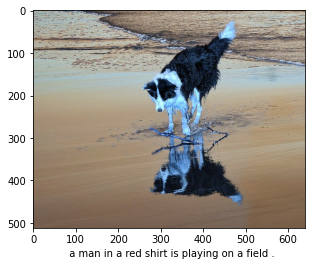

In [ ]:
import matplotlib.pyplot as plt
path = '/content/drive/MyDrive/ImCap/ImageCaptioning/example.jpg'
image = cv2.imread(path)
plt.imshow(image)
plt.xlabel(caption)

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	example.jpg
	model.png
	model_0.h5
	soeun.jpg

nothing added to commit but untracked files present (use "git add" to track)
